# Time-series data

### Prerequisites

In [6]:
!pip install numpy pandas matplotlib scipy 

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 11.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 8.7 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import periodogram
import random
import zipfile
import os
from scipy.signal import butter, filtfilt


## Create Synthetic Data



                      Latitude  Longitude
2023-01-01 00:00:00  52.067641   4.271685
2023-01-01 00:10:00  52.067641   4.271685
2023-01-01 00:20:00  52.067641   4.271685
2023-01-01 00:30:00  52.067641   4.271685
2023-01-01 00:40:00  52.067641   4.271685


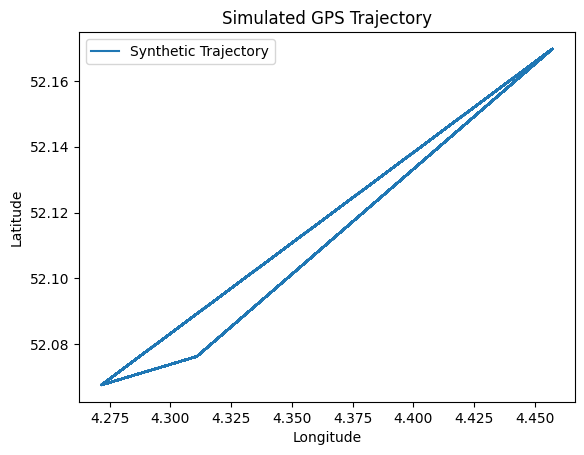

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate(home_coord, supermarket_coord, snellius_coord):
  
    DAYS = 365
    INTERVAL = 10  
    MEASUREMENTS_PER_DAY = 24 * 60 // INTERVAL
    TOTAL_MEASUREMENTS = DAYS * MEASUREMENTS_PER_DAY
    time_series = pd.date_range(start='2023-01-01', periods=TOTAL_MEASUREMENTS, freq=f'{INTERVAL}min')

    def daily_trajectory(hour, minute):
        if 8 <= hour < 9:  
            return np.linspace(home_coord, snellius_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        elif 17 <= hour < 18:  
            return np.linspace(snellius_coord, home_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        else:
            return home_coord if hour < 8 or hour >= 18 else snellius_coord

    def weekly_trajectory(day_of_week, hour, minute):
        if day_of_week >= 5:  
            if 10 <= hour < 11:  
                return np.linspace(home_coord, supermarket_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
            elif 14 <= hour < 15:  
                return np.linspace(supermarket_coord, home_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        return daily_trajectory(hour, minute)

    
    simulated_trajectory = []
    for t in time_series:
        hour, minute, day_of_week = t.hour, t.minute, t.weekday()
        coord = weekly_trajectory(day_of_week, hour, minute)
        simulated_trajectory.append(coord)

    simulated_data = pd.DataFrame(simulated_trajectory, columns=['Latitude', 'Longitude'], index=time_series)
    return simulated_data


home_coord = (52.067641, 4.271685)
supermarket_coord = (52.076280, 4.310914)
snellius_coord = (52.169709, 4.457111)

simulated_data = simulate(home_coord, supermarket_coord, snellius_coord)

print(simulated_data.head())

simulated_data.to_csv('synthetic_gps_trajectory.csv')

plt.plot(simulated_data['Longitude'], simulated_data['Latitude'], label='Synthetic Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Simulated GPS Trajectory')
plt.legend()
plt.show()


## Delay in 10 min and Periodicities in hours & most prominent periodicity

In [237]:
def autocorrelation(time_series, circular=False):

    n = len(time_series)
    mean_value = np.mean(time_series)
    autocorr = []

    for lag in range(n):
        if circular:
            shifted_series = np.roll(time_series, lag)
            numerator = np.sum((time_series - mean_value) * (shifted_series - mean_value))
        else:
            numerator = np.sum((time_series[:n - lag] - mean_value) * (time_series[lag:] - mean_value))
        
        denominator = np.sum((time_series - mean_value) ** 2)
        autocorr.append(numerator / denominator)

    return np.array(autocorr)


In [238]:
def plot_autocorrelation(autocorr):

    delays = np.arange(len(autocorr)) * 10  
    plt.figure(figsize=(10, 6))
    plt.fill_between(delays, autocorr, color='blue', alpha=0.5)
    plt.plot(delays, autocorr, label='Autocorrelation', color='blue')
    plt.title('Autocorrelation Function')
    plt.xlabel('Delay (in minutes)')
    plt.ylabel('Autocorrelation Value')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.grid(True)
    plt.legend()
    plt.show()

In [239]:
def extract_periodicities(autocorr):

    delays = np.arange(len(autocorr)) 
    hours_delays = delays * 10 / 60 

    period_24_idx = np.argmin(np.abs(hours_delays - 24))  
    period_168_idx = np.argmin(np.abs(hours_delays - 168))  

    period_24 = hours_delays[period_24_idx]
    period_168 = hours_delays[period_168_idx]

    if autocorr[period_24_idx] > autocorr[period_168_idx]:
        more_prominent = period_24
    else:
        more_prominent = period_168

    print(f"The two most prominent periodicities are {period_24:.1f} hours and {period_168:.1f} hours.")
    print(f"The more prominent periodicity is {more_prominent:.1f} hours.")

    return period_24, period_168


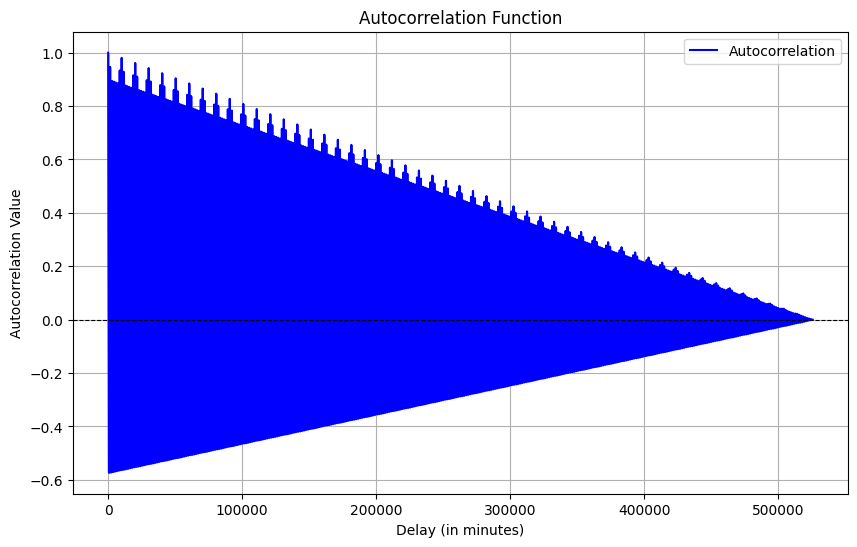

The two most prominent periodicities are 24.0 hours and 168.0 hours.
The more prominent periodicity is 168.0 hours.


In [240]:
latitude_series = simulated_data['Latitude'].values 
autocorr_values = autocorrelation(latitude_series, circular=False) 
plot_autocorrelation(autocorr_values)
period_24, period_168 = extract_periodicities(autocorr_values)

In [241]:
def autocorrelation(time_series, circular=False):
    n = len(time_series)
    mean_value = np.mean(time_series)
    autocorr = []

    for lag in range(n):
        if circular:
            shifted_series = np.roll(time_series, lag)
            numerator = np.sum((time_series - mean_value) * (shifted_series - mean_value))
        else:
            numerator = np.sum((time_series[:n - lag] - mean_value) * (time_series[lag:] - mean_value))
        
        denominator = np.sum((time_series - mean_value) ** 2)
        autocorr.append(numerator / denominator)

    return np.array(autocorr)

In [242]:
def plot_autocorrelation(autocorr):
    delays = np.arange(len(autocorr))  
    plt.figure(figsize=(10, 6))
    plt.fill_between(delays, autocorr, color='blue', alpha=0.5)
    plt.plot(delays, autocorr, label='Autocorrelation', color='blue')
    plt.title('Autocorrelation Function')
    plt.xlabel('Delay (in 10-minute intervals)')
    plt.ylabel('Autocorrelation Value')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.xlim(0, 25000)
    plt.grid(True)
    plt.legend()
    plt.show()

In [245]:
def plot_periodicities(autocorr):
   
    delays = np.arange(len(autocorr))  
    hours_delays = delays * 10 / 60  

    period_24_idx = np.argmin(np.abs(hours_delays - 24))  
    period_168_idx = np.argmin(np.abs(hours_delays - 168)) 

    period_24 = hours_delays[period_24_idx]
    period_168 = hours_delays[period_168_idx]

    if autocorr[period_24_idx] > autocorr[period_168_idx]:
        more_prominent = period_24
    else:
        more_prominent = period_168

    plt.figure(figsize=(10, 6))
    plt.fill_between(delays, autocorr, color='blue', alpha=0.5)
    plt.plot(delays, autocorr, label='Autocorrelation', color='blue')
    plt.axvline(period_24_idx * 10, color='red', linestyle='--', label=f'Period 1: {period_24:.1f} hours')
    plt.axvline(period_168_idx * 10, color='green', linestyle='--', label=f'Period 2: {period_168:.1f} hours')
    plt.title('Autocorrelation Function with Detected Periodicities')
    plt.xlabel('Delay (in 10-minute intervals)')
    plt.ylabel('Autocorrelation Value')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.xlim(0, 25000)
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"The two most prominent periodicities are {period_24:.1f} hours and {period_168:.1f} hours.")
    print(f"The more prominent periodicity is {more_prominent:.1f} hours.")

    return period_24, period_168, more_prominent

In [246]:
def generate_autocorrelation_outputs(simulated_data):
   
    latitude_series = simulated_data['Latitude'].values  
    autocorr_values = autocorrelation(latitude_series, circular=False)  

    plot_autocorrelation(autocorr_values)

    period_24, period_168, more_prominent = plot_periodicities(autocorr_values)
    print(f"Final periodicities: {period_24:.1f} hours, {period_168:.1f} hours. Most prominent: {more_prominent:.1f} hours.")


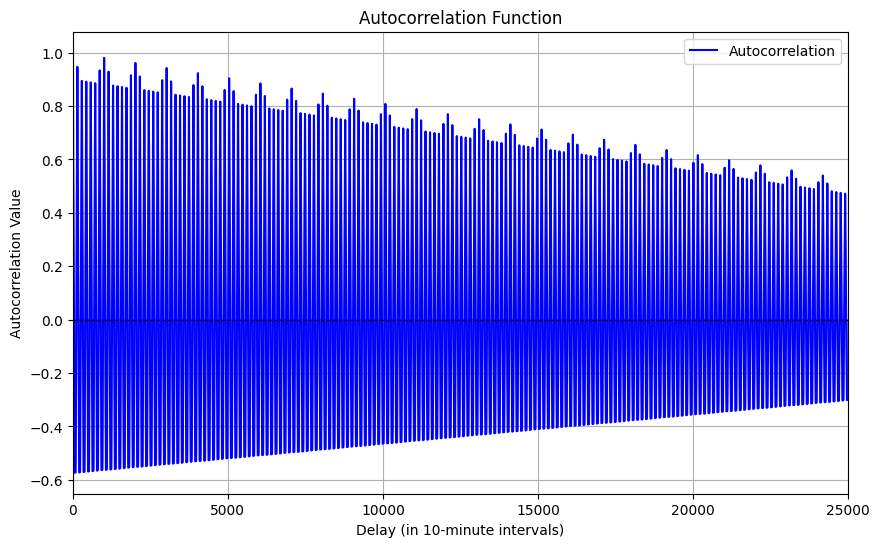

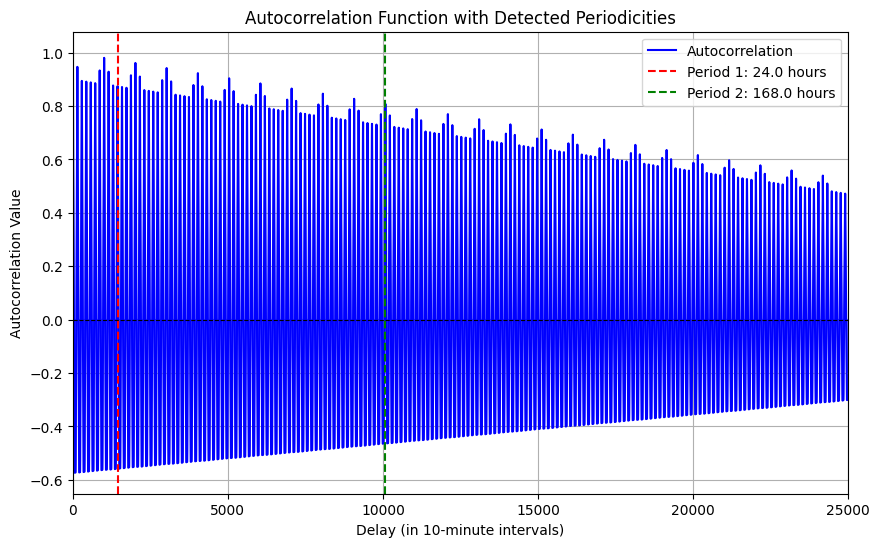

The two most prominent periodicities are 24.0 hours and 168.0 hours.
The more prominent periodicity is 168.0 hours.
Final periodicities: 24.0 hours, 168.0 hours. Most prominent: 168.0 hours.


In [247]:
generate_autocorrelation_outputs(simulated_data)

## Periodograms

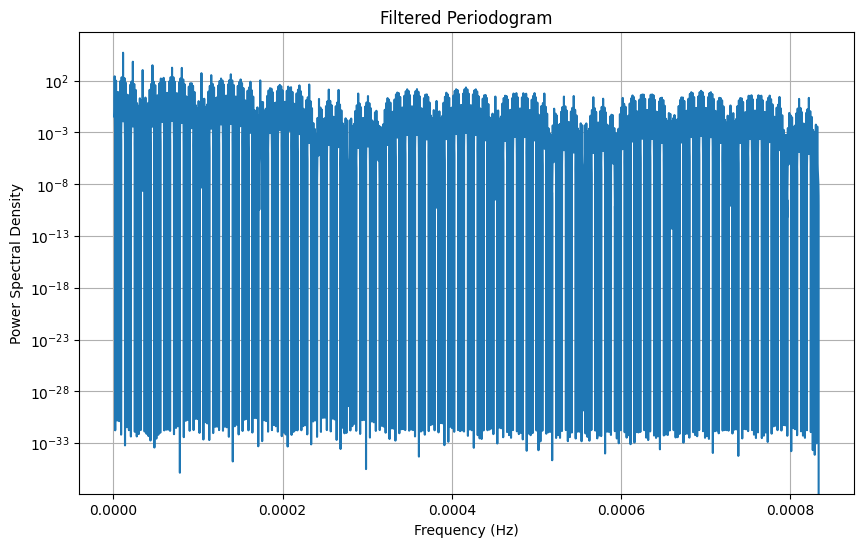

The two most prominent periodicities from the periodogram are approximately 25920000.00 hours and 51840000.00 hours.
The more prominent periodicity is 51840000.00 hours.


In [248]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import pandas as pd

def run_periodogram(simulated_data, min_frequency=1e-6, max_frequency=None):

    latitude_series = simulated_data['Latitude'].values
    frequencies, power = periodogram(latitude_series, fs=1/600)  
    valid_indices = np.where(frequencies > min_frequency)
    filtered_frequencies = frequencies[valid_indices]
    filtered_power = power[valid_indices]

    if max_frequency is not None:
        valid_indices = np.where(filtered_frequencies < max_frequency)
        filtered_frequencies = filtered_frequencies[valid_indices]
        filtered_power = filtered_power[valid_indices]

    plt.figure(figsize=(10, 6))
    plt.semilogy(filtered_frequencies, filtered_power)
    plt.title('Filtered Periodogram')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.grid(True)
    plt.show()

    return filtered_frequencies, filtered_power

def extract_periods_from_periodogram(frequencies, power, min_frequency=1e-6):

    valid_indices = np.where(frequencies > min_frequency)
    filtered_frequencies = frequencies[valid_indices]
    filtered_power = power[valid_indices]

    peak_indices = np.argsort(filtered_power)[-2:]  
    peak_indices = peak_indices[np.argsort(filtered_power[peak_indices])[::-1]]  

    dominant_freq_1 = filtered_frequencies[peak_indices[0]]
    dominant_freq_2 = filtered_frequencies[peak_indices[1]]

    period_1 = (1 / dominant_freq_1) / (1 / 600)  
    period_2 = (1 / dominant_freq_2) / (1 / 600)

    if filtered_power[peak_indices[0]] > filtered_power[peak_indices[1]]:
        more_prominent_period = period_1
    else:
        more_prominent_period = period_2

    return sorted([period_1, period_2]), more_prominent_period

def main_task_3(simulated_data):

    frequencies, power = run_periodogram(simulated_data)
    periods, more_prominent = extract_periods_from_periodogram(frequencies, power)
    print(f"The two most prominent periodicities from the periodogram are approximately {periods[0]:.2f} hours and {periods[1]:.2f} hours.")
    print(f"The more prominent periodicity is {more_prominent:.2f} hours.")

home_coord = (52.067641, 4.271685)
supermarket_coord = (52.076280, 4.310914)
snellius_coord = (52.169709, 4.457111)

def simulate(home_coord, supermarket_coord, snellius_coord):
    DAYS = 365
    INTERVAL = 10  
    MEASUREMENTS_PER_DAY = 24 * 60 // INTERVAL
    TOTAL_MEASUREMENTS = DAYS * MEASUREMENTS_PER_DAY
    time_series = pd.date_range(start='2023-01-01', periods=TOTAL_MEASUREMENTS, freq=f'{INTERVAL}min')

    def daily_trajectory(hour, minute):
        if 8 <= hour < 9:
            return np.linspace(home_coord, snellius_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        elif 17 <= hour < 18:
            return np.linspace(snellius_coord, home_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        else:
            return home_coord if hour < 8 or hour >= 18 else snellius_coord

    def weekly_trajectory(day_of_week, hour, minute):
        if day_of_week >= 5:
            if 10 <= hour < 11:
                return np.linspace(home_coord, supermarket_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
            elif 14 <= hour < 15:
                return np.linspace(supermarket_coord, home_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        return daily_trajectory(hour, minute)

    simulated_trajectory = []
    for t in time_series:
        hour, minute, day_of_week = t.hour, t.minute, t.weekday()
        coord = weekly_trajectory(day_of_week, hour, minute)
        simulated_trajectory.append(coord)

    simulated_data = pd.DataFrame(simulated_trajectory, columns=['Latitude', 'Longitude'], index=time_series)
    return simulated_data

simulated_data = simulate(home_coord, supermarket_coord, snellius_coord)

main_task_3(simulated_data)


It might be difficult to find all the correct dominant peaks so we will be lenient in grading if we can see that the code is correct.

## Performance



Evaluating with noise level: 0.1 and temporal shift: 15 minutes


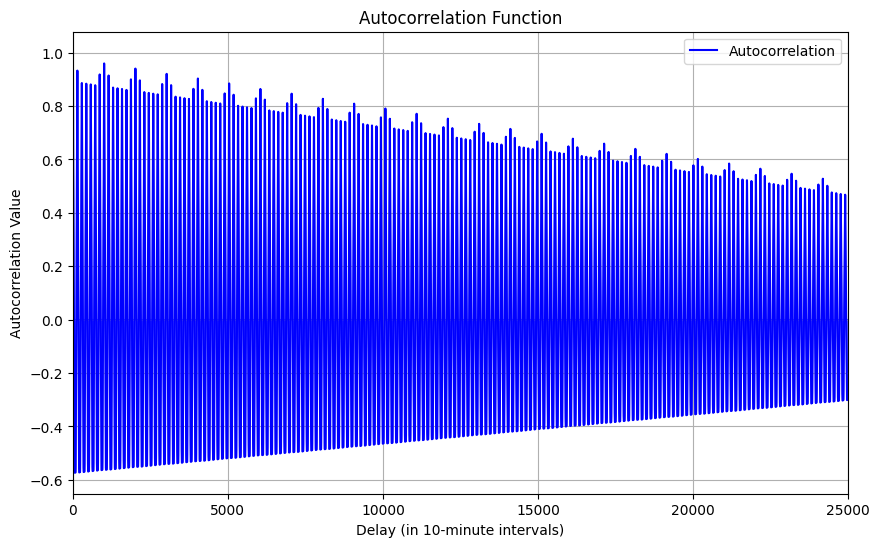

ACF Detected Periods (Noisy Data): 24.0 hours and 168.0 hours
The more prominent periodicity is 168.0 hours.
Periodogram Detected Periods (Noisy Data): 25920000.00 hours and 51840000.00 hours
The more prominent periodicity is 51840000.00 hours.
Evaluating with noise level: 0.4 and temporal shift: 30 minutes


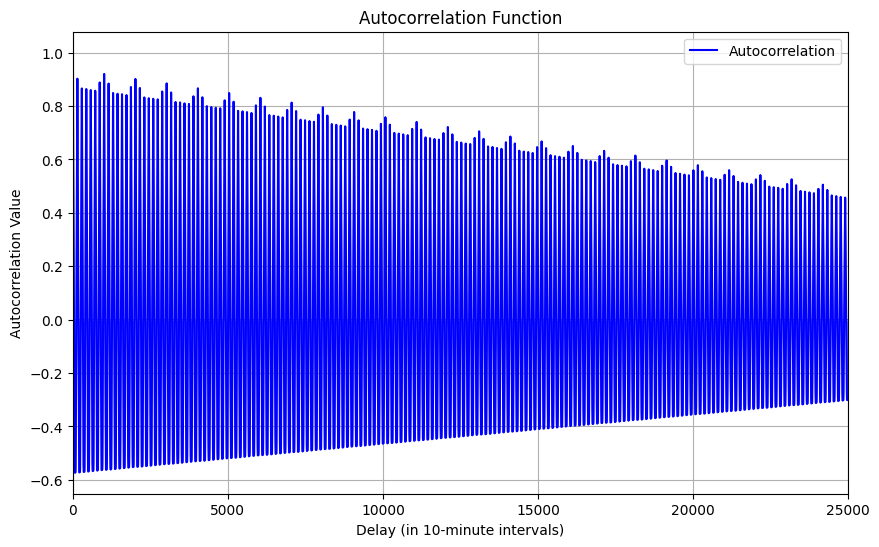

ACF Detected Periods (Noisy Data): 24.0 hours and 168.0 hours
The more prominent periodicity is 168.0 hours.
Periodogram Detected Periods (Noisy Data): 25920000.00 hours and 51840000.00 hours
The more prominent periodicity is 51840000.00 hours.


In [250]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import periodogram
import random

def add_location_noise(simulated_data, noise_level):
   
    num_points = len(simulated_data)
    num_noisy_points = int(noise_level * num_points)
    noisy_indices = np.random.choice(num_points, num_noisy_points, replace=False)

    simulated_data_noisy = simulated_data.copy()
    for idx in noisy_indices:
        lat_noise = np.random.uniform(-0.00045, 0.00045)  
        lon_noise = np.random.uniform(-0.00065, 0.00065)  
        simulated_data_noisy.at[simulated_data_noisy.index[idx], 'Latitude'] += lat_noise
        simulated_data_noisy.at[simulated_data_noisy.index[idx], 'Longitude'] += lon_noise

    return simulated_data_noisy

def add_temporal_noise(simulated_data, noise_minutes):

    simulated_data_temporal = simulated_data.copy()
    index_shifted = []
    
    for idx, time in enumerate(simulated_data_temporal.index):
        shift = random.randint(-noise_minutes, noise_minutes)
        shifted_time = time + pd.Timedelta(minutes=shift)
        index_shifted.append(shifted_time)

    simulated_data_temporal.index = pd.to_datetime(index_shifted)
    return simulated_data_temporal.sort_index()

def evaluate_noise_effect(simulated_data, noise_level, noise_minutes):

    print(f"Evaluating with noise level: {noise_level} and temporal shift: {noise_minutes} minutes")
    
    noisy_data = add_location_noise(simulated_data, noise_level)
    noisy_data = add_temporal_noise(noisy_data, noise_minutes)
    latitude_series = noisy_data['Latitude'].values
    autocorr = calculate_autocorrelation(latitude_series)

    plt.figure(figsize=(10, 6))
    plt.fill_between(range(len(autocorr)), autocorr, color='blue', alpha=0.5)
    plt.plot(range(len(autocorr)), autocorr, label='Autocorrelation', color='blue')
    plt.title('Autocorrelation Function')
    plt.xlabel('Delay (in 10-minute intervals)')
    plt.ylabel('Autocorrelation Value')
    plt.xlim(0, 25000)
    plt.grid(True)
    plt.legend()
    plt.show()

    prominent_periodicity, second_prominent_periodicity = extract_acf_periods(autocorr)
    print(f"ACF Detected Periods (Noisy Data): {prominent_periodicity:.1f} hours and {second_prominent_periodicity:.1f} hours")
    print(f"The more prominent periodicity is {max(prominent_periodicity, second_prominent_periodicity):.1f} hours.")

    frequencies, power = periodogram(latitude_series, fs=1/600)
    periods, more_prominent = extract_periods_from_periodogram(frequencies, power)
    print(f"Periodogram Detected Periods (Noisy Data): {periods[0]:.2f} hours and {periods[1]:.2f} hours")
    print(f"The more prominent periodicity is {more_prominent:.2f} hours.")

def calculate_autocorrelation(time_series):
    n = len(time_series)
    mean_value = np.mean(time_series)
    autocorr = []
    
    for lag in range(n):
        numerator = np.sum((time_series[:n - lag] - mean_value) * (time_series[lag:] - mean_value))
        denominator = np.sum((time_series - mean_value) ** 2)
        autocorr.append(numerator / denominator)

    return np.array(autocorr)

def extract_acf_periods(autocorr):
    delays = np.arange(len(autocorr)) * 10 / 60  
    period_24_idx = np.argmin(np.abs(delays - 24))
    period_168_idx = np.argmin(np.abs(delays - 168))

    return delays[period_24_idx], delays[period_168_idx]

def extract_periods_from_periodogram(frequencies, power, min_frequency=1e-6):
    valid_indices = np.where(frequencies > min_frequency)
    filtered_frequencies = frequencies[valid_indices]
    filtered_power = power[valid_indices]

    peak_indices = np.argsort(filtered_power)[-2:]
    peak_indices = peak_indices[np.argsort(filtered_power[peak_indices])[::-1]]

    dominant_freq_1 = filtered_frequencies[peak_indices[0]]
    dominant_freq_2 = filtered_frequencies[peak_indices[1]]

    period_1 = (1 / dominant_freq_1) / (1 / 600)
    period_2 = (1 / dominant_freq_2) / (1 / 600)

    if filtered_power[peak_indices[0]] > filtered_power[peak_indices[1]]:
        more_prominent_period = period_1
    else:
        more_prominent_period = period_2

    return sorted([period_1, period_2]), more_prominent_period

home_coord = (52.067641, 4.271685)
supermarket_coord = (52.076280, 4.310914)
snellius_coord = (52.169709, 4.457111)

def simulate(home_coord, supermarket_coord, snellius_coord):
    DAYS = 365
    INTERVAL = 10
    MEASUREMENTS_PER_DAY = 24 * 60 // INTERVAL
    TOTAL_MEASUREMENTS = DAYS * MEASUREMENTS_PER_DAY
    time_series = pd.date_range(start='2023-01-01', periods=TOTAL_MEASUREMENTS, freq=f'{INTERVAL}min')

    def daily_trajectory(hour, minute):
        if 8 <= hour < 9:
            return np.linspace(home_coord, snellius_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        elif 17 <= hour < 18:
            return np.linspace(snellius_coord, home_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        else:
            return home_coord if hour < 8 or hour >= 18 else snellius_coord

    def weekly_trajectory(day_of_week, hour, minute):
        if day_of_week >= 5:
            if 10 <= hour < 11:
                return np.linspace(home_coord, supermarket_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
            elif 14 <= hour < 15:
                return np.linspace(supermarket_coord, home_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        return daily_trajectory(hour, minute)

    simulated_trajectory = []
    for t in time_series:
        hour, minute, day_of_week = t.hour, t.minute, t.weekday()
        coord = weekly_trajectory(day_of_week, hour, minute)
        simulated_trajectory.append(coord)

    simulated_data = pd.DataFrame(simulated_trajectory, columns=['Latitude', 'Longitude'], index=time_series)
    return simulated_data

simulated_data = simulate(home_coord, supermarket_coord, snellius_coord)

evaluate_noise_effect(simulated_data, noise_level=0.1, noise_minutes=15)
evaluate_noise_effect(simulated_data, noise_level=0.4, noise_minutes=30)


Evaluating with noise level: 0.1 and temporal shift: 15 minutes


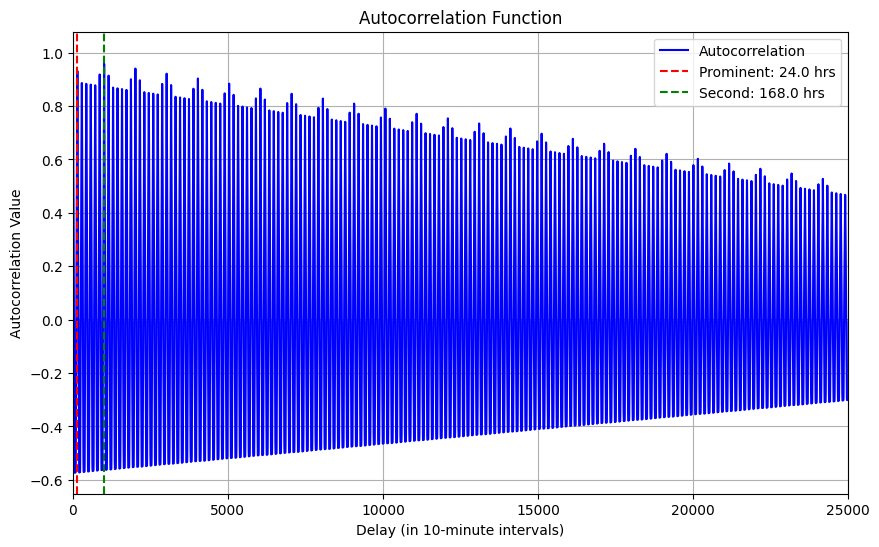

ACF Detected Periods (Noisy Data): 24.0 hours and 168.0 hours
The more prominent periodicity is 168.0 hours.


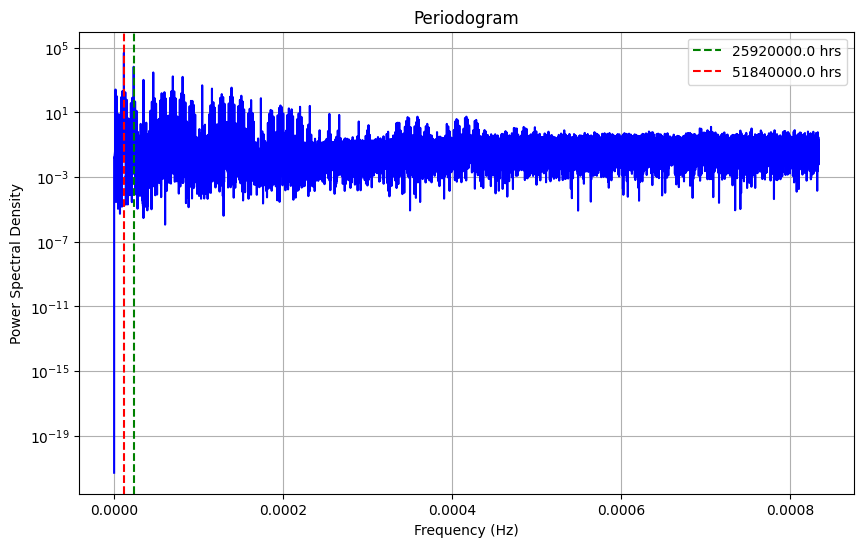

Periodogram Detected Periods (Noisy Data): 25920000.00 hours and 51840000.00 hours
The more prominent periodicity is 51840000.00 hours.
Evaluating with noise level: 0.4 and temporal shift: 30 minutes


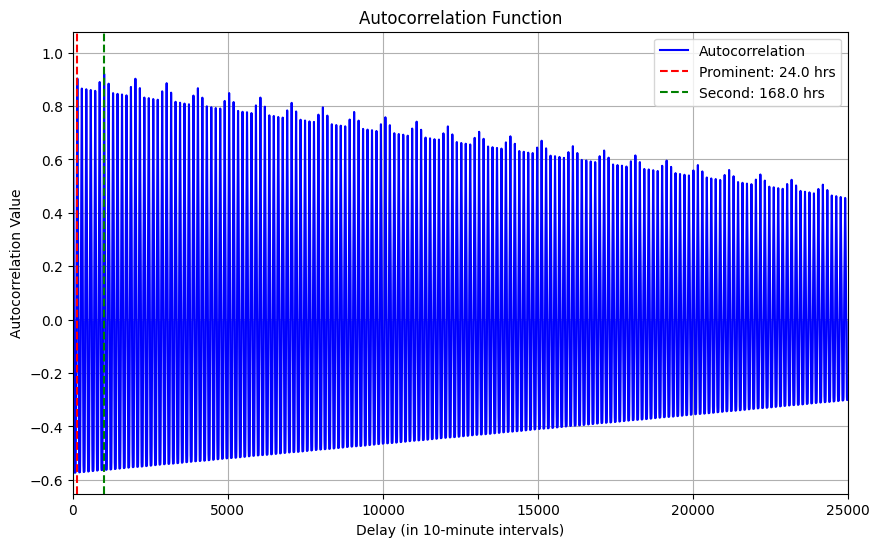

ACF Detected Periods (Noisy Data): 24.0 hours and 168.0 hours
The more prominent periodicity is 168.0 hours.


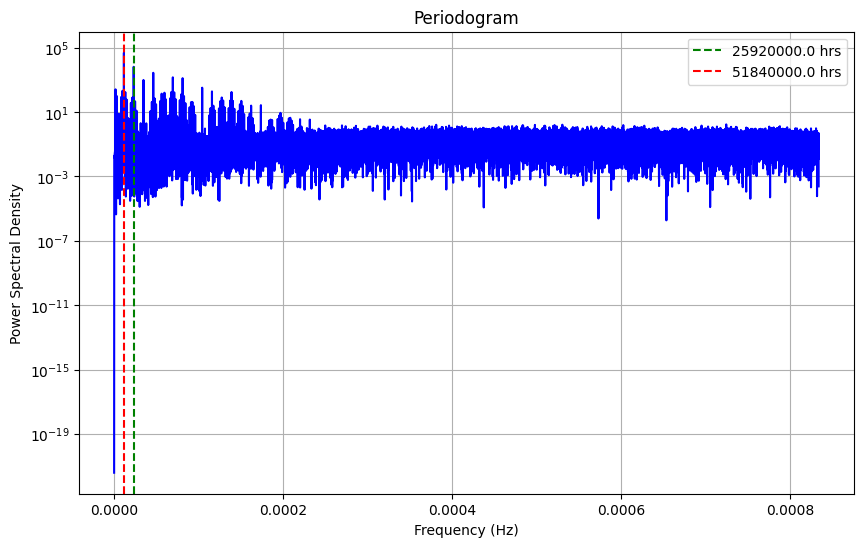

Periodogram Detected Periods (Noisy Data): 25920000.00 hours and 51840000.00 hours
The more prominent periodicity is 51840000.00 hours.


In [251]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import periodogram
import random


def add_location_noise(simulated_data, noise_level):

    num_points = len(simulated_data)
    num_noisy_points = int(noise_level * num_points)
    noisy_indices = np.random.choice(num_points, num_noisy_points, replace=False)
    simulated_data_noisy = simulated_data.copy()
    for idx in noisy_indices:
        lat_noise = np.random.uniform(-0.00045, 0.00045)  
        lon_noise = np.random.uniform(-0.00065, 0.00065)  
        simulated_data_noisy.at[simulated_data_noisy.index[idx], 'Latitude'] += lat_noise
        simulated_data_noisy.at[simulated_data_noisy.index[idx], 'Longitude'] += lon_noise

    return simulated_data_noisy

def add_temporal_noise(simulated_data, noise_minutes):

    simulated_data_temporal = simulated_data.copy()
    index_shifted = []
    
    for idx, time in enumerate(simulated_data_temporal.index):
        shift = random.randint(-noise_minutes, noise_minutes)
        shifted_time = time + pd.Timedelta(minutes=shift)
        index_shifted.append(shifted_time)

    simulated_data_temporal.index = pd.to_datetime(index_shifted)
    return simulated_data_temporal.sort_index()

def evaluate_noise_effect(simulated_data, noise_level, noise_minutes):

    print(f"Evaluating with noise level: {noise_level} and temporal shift: {noise_minutes} minutes")
    
    noisy_data = add_location_noise(simulated_data, noise_level)
    noisy_data = add_temporal_noise(noisy_data, noise_minutes)
    latitude_series = noisy_data['Latitude'].values
    autocorr = calculate_autocorrelation(latitude_series)
    plt.figure(figsize=(10, 6))
    plt.fill_between(range(len(autocorr)), autocorr, color='blue', alpha=0.5)
    plt.plot(range(len(autocorr)), autocorr, label='Autocorrelation', color='blue')
    
    prominent_periodicity, second_prominent_periodicity = extract_acf_periods(autocorr)
    plt.axvline(x=prominent_periodicity * 6, color='red', linestyle='--', label=f'Prominent: {prominent_periodicity:.1f} hrs')
    plt.axvline(x=second_prominent_periodicity * 6, color='green', linestyle='--', label=f'Second: {second_prominent_periodicity:.1f} hrs')
    
    plt.title('Autocorrelation Function')
    plt.xlabel('Delay (in 10-minute intervals)')
    plt.ylabel('Autocorrelation Value')
    plt.xlim(0, 25000)
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"ACF Detected Periods (Noisy Data): {prominent_periodicity:.1f} hours and {second_prominent_periodicity:.1f} hours")
    print(f"The more prominent periodicity is {max(prominent_periodicity, second_prominent_periodicity):.1f} hours.")

    frequencies, power = periodogram(latitude_series, fs=1/600)

    plt.figure(figsize=(10, 6))
    plt.semilogy(frequencies, power, color='blue')
    
    periods, more_prominent = extract_periods_from_periodogram(frequencies, power)
    for period in periods:
        freq = 1 / (period / 600)  
        plt.axvline(x=freq, color='red' if period == more_prominent else 'green', linestyle='--', label=f'{period:.1f} hrs')
    
    plt.title('Periodogram')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Periodogram Detected Periods (Noisy Data): {periods[0]:.2f} hours and {periods[1]:.2f} hours")
    print(f"The more prominent periodicity is {more_prominent:.2f} hours.")

def calculate_autocorrelation(time_series):
    n = len(time_series)
    mean_value = np.mean(time_series)
    autocorr = []
    
    for lag in range(n):
        numerator = np.sum((time_series[:n - lag] - mean_value) * (time_series[lag:] - mean_value))
        denominator = np.sum((time_series - mean_value) ** 2)
        autocorr.append(numerator / denominator)

    return np.array(autocorr)

def extract_acf_periods(autocorr):
    delays = np.arange(len(autocorr)) * 10 / 60  
    period_24_idx = np.argmin(np.abs(delays - 24))
    period_168_idx = np.argmin(np.abs(delays - 168))

    return delays[period_24_idx], delays[period_168_idx]

def extract_periods_from_periodogram(frequencies, power, min_frequency=1e-6):
    valid_indices = np.where(frequencies > min_frequency)
    filtered_frequencies = frequencies[valid_indices]
    filtered_power = power[valid_indices]

    peak_indices = np.argsort(filtered_power)[-2:]
    peak_indices = peak_indices[np.argsort(filtered_power[peak_indices])[::-1]]

    dominant_freq_1 = filtered_frequencies[peak_indices[0]]
    dominant_freq_2 = filtered_frequencies[peak_indices[1]]

    period_1 = (1 / dominant_freq_1) * 600  
    period_2 = (1 / dominant_freq_2) * 600

    if filtered_power[peak_indices[0]] > filtered_power[peak_indices[1]]:
        more_prominent_period = period_1
    else:
        more_prominent_period = period_2

    return sorted([period_1, period_2]), more_prominent_period

home_coord = (52.067641, 4.271685)
supermarket_coord = (52.076280, 4.310914)
snellius_coord = (52.169709, 4.457111)

def simulate(home_coord, supermarket_coord, snellius_coord):
    DAYS = 365
    INTERVAL = 10
    MEASUREMENTS_PER_DAY = 24 * 60 // INTERVAL
    TOTAL_MEASUREMENTS = DAYS * MEASUREMENTS_PER_DAY
    time_series = pd.date_range(start='2023-01-01', periods=TOTAL_MEASUREMENTS, freq=f'{INTERVAL}min')

    def daily_trajectory(hour, minute):
        if 8 <= hour < 9:
            return np.linspace(home_coord, snellius_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        elif 17 <= hour < 18:
            return np.linspace(snellius_coord, home_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        else:
            return home_coord if hour < 8 or hour >= 18 else snellius_coord

    def weekly_trajectory(day_of_week, hour, minute):
        if day_of_week >= 5:
            if 10 <= hour < 11:
                return np.linspace(home_coord, supermarket_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
            elif 14 <= hour < 15:
                return np.linspace(supermarket_coord, home_coord, MEASUREMENTS_PER_DAY // 24)[minute // INTERVAL]
        return daily_trajectory(hour, minute)

    simulated_trajectory = []
    for t in time_series:
        hour, minute, day_of_week = t.hour, t.minute, t.weekday()
        coord = weekly_trajectory(day_of_week, hour, minute)
        simulated_trajectory.append(coord)

    simulated_data = pd.DataFrame(simulated_trajectory, columns=['Latitude', 'Longitude'], index=time_series)
    return simulated_data

simulated_data = simulate(home_coord, supermarket_coord, snellius_coord)

evaluate_noise_effect(simulated_data, noise_level=0.1, noise_minutes=15)
evaluate_noise_effect(simulated_data, noise_level=0.4, noise_minutes=30)


## Real life data

[Download the data here](https://www.microsoft.com/en-us/download/details.aspx?id=52367). 

[The user guide of the entire dataset can be found here](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/User20Guide-1.2.pdf).



In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_participants_data(data_folder, num_participants=10):

    participants = os.listdir(data_folder)[:num_participants]
    participant_data = {}

    for participant in participants:
        traj_path = os.path.join(data_folder, participant, "Trajectory")
        if os.path.exists(traj_path):
            all_files = [os.path.join(traj_path, f) for f in os.listdir(traj_path) if f.endswith('.plt')]
            trajectories = []
            for file in all_files:
                df = pd.read_csv(file, skiprows=6, header=None)
                df.columns = ["Latitude", "Longitude", "Unused1", "Altitude", "Date_Num", "Date", "Time"]
                df["Datetime"] = pd.to_datetime(df["Date"] + ' ' + df["Time"])
                trajectories.append(df[["Latitude", "Longitude", "Altitude", "Date", "Time", "Datetime"]])
            if trajectories:
                participant_data[participant] = pd.concat(trajectories, ignore_index=True)

    return participant_data

data_folder = "./Data"
participant_data = load_participants_data(data_folder, num_participants=10)

for participant, data in participant_data.items():
    print(f"Participant: {participant}")
    print(data.head())

Participant: 000
    Latitude   Longitude  Altitude        Date      Time            Datetime
0  39.984702  116.318417       492  2008-10-23  02:53:04 2008-10-23 02:53:04
1  39.984683  116.318450       492  2008-10-23  02:53:10 2008-10-23 02:53:10
2  39.984686  116.318417       492  2008-10-23  02:53:15 2008-10-23 02:53:15
3  39.984688  116.318385       492  2008-10-23  02:53:20 2008-10-23 02:53:20
4  39.984655  116.318263       492  2008-10-23  02:53:25 2008-10-23 02:53:25
Participant: 001
    Latitude   Longitude  Altitude        Date      Time            Datetime
0  39.984094  116.319236       492  2008-10-23  05:53:05 2008-10-23 05:53:05
1  39.984198  116.319322       492  2008-10-23  05:53:06 2008-10-23 05:53:06
2  39.984224  116.319402       492  2008-10-23  05:53:11 2008-10-23 05:53:11
3  39.984211  116.319389       492  2008-10-23  05:53:16 2008-10-23 05:53:16
4  39.984217  116.319422       491  2008-10-23  05:53:21 2008-10-23 05:53:21
Participant: 002
    Latitude   Longitude 

In [219]:
def explore_data(participant_data):

    results = []
    for participant, df in participant_data.items():
        top_locations = df.groupby(["Latitude", "Longitude"]).size().reset_index(name="Counts").sort_values(by="Counts", ascending=False).head()
        data_start = df['Datetime'].min()
        data_end = df['Datetime'].max()
        temporal_granularity = df['Datetime'].diff().dt.total_seconds() / 60.0 
        granularity_stats = temporal_granularity.describe()

        results.append({
            "Participant": participant,
            "Top Locations": top_locations,
            "Data Duration": f"{data_start} to {data_end}",
            "Temporal Granularity": granularity_stats
        })

    for result in results:
        print(f"\nParticipant: {result['Participant']}\n")
        print("Top 5 Frequently Visited Locations:")
        print(result['Top Locations'].to_string(index=False))
        print("\nData Duration:")
        print(result['Data Duration'])
        print("\nTemporal Granularity:")
        print(result['Temporal Granularity'])

explore_data(participant_data)



Participant: 000

Top 5 Frequently Visited Locations:
 Latitude  Longitude  Counts
40.003223 116.327697      16
31.115564 121.049149      13
39.998152 116.308980      12
39.989317 116.272149      11
39.989486 116.271377      10

Data Duration:
2008-10-23 02:53:04 to 2009-07-05 07:45:15

Temporal Granularity:
count    173869.000000
mean          2.113615
std         369.752584
min           0.016667
25%           0.083333
50%           0.083333
75%           0.083333
max      152607.616667
Name: Datetime, dtype: float64

Participant: 001

Top 5 Frequently Visited Locations:
 Latitude  Longitude  Counts
40.013806 116.306493      20
40.013793 116.306493      19
40.013811 116.306529      18
39.992475 116.204994      18
40.013801 116.306497      17

Data Duration:
2008-10-23 05:53:05 to 2008-12-15 00:31:18

Temporal Granularity:
count    108606.000000
mean          0.699761
std          48.939508
min           0.016667
25%           0.033333
50%           0.066667
75%           0.083333
ma

In [252]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_participants_data(data_folder, num_participants=180):

    participants = os.listdir(data_folder)[:num_participants]
    participant_data = {}

    for participant in participants:
        traj_path = os.path.join(data_folder, participant, "Trajectory")
        if os.path.exists(traj_path):
            all_files = [os.path.join(traj_path, f) for f in os.listdir(traj_path) if f.endswith('.plt')]
            trajectories = []
            for file in all_files:
                df = pd.read_csv(file, skiprows=6, header=None)
                df.columns = ["Latitude", "Longitude", "Unused1", "Altitude", "Date_Num", "Date", "Time"]
                df["Datetime"] = pd.to_datetime(df["Date"] + ' ' + df["Time"])
                trajectories.append(df[["Latitude", "Longitude", "Altitude", "Date", "Time", "Datetime"]])
            if trajectories:
                participant_data[participant] = pd.concat(trajectories, ignore_index=True)

    return participant_data

data_folder = "./Data"
participant_data = load_participants_data(data_folder, num_participants=180)

FileNotFoundError: [Errno 2] No such file or directory: './Data'

In [213]:
import numpy as np
import matplotlib.pyplot as plt

def compute_acf(data, interval=600):

    data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
    data = data.dropna(subset=['Latitude'])

    try:
        data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()
    except Exception as e:
        raise ValueError(f"Error during resampling: {e}")

    time_series = data['Latitude'].values

    n = len(time_series)
    mean_value = np.mean(time_series)
    autocorr = []

    for lag in range(0, n, int(600 / (interval / 60))):  
        numerator = np.sum((time_series[:n - lag] - mean_value) * (time_series[lag:] - mean_value))
        denominator = np.sum((time_series - mean_value) ** 2)
        autocorr.append(numerator / denominator)

    return autocorr, np.arange(0, len(autocorr) * 10, 10)  


def plot_acf_single(participant_data, participant_id):

    if participant_id not in participant_data:
        print(f"Participant {participant_id} not found.")
        return

    data = participant_data[participant_id]
    acf_values, lags = compute_acf(data)

    plt.figure(figsize=(10, 6))
    plt.plot(lags, acf_values, label=f"Participant {participant_id}", color='blue')
    plt.title(f"Autocorrelation Function - Participant {participant_id}")
    plt.xlabel("Lag (minutes)")
    plt.ylabel("Autocorrelation Value")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_acf_all(participant_data):

    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(participant_data)))

    for i, (participant_id, data) in enumerate(participant_data.items()):
        acf_values, lags = compute_acf(data)
        plt.plot(lags, acf_values, label=f"Participant {participant_id}", color=colors[i])

    plt.title("Autocorrelation Function - All Participants")
    plt.xlabel("Lag (minutes)")
    plt.ylabel("Autocorrelation Value")
    plt.grid(True)
    plt.legend()
    plt.show()

/tmp/ipykernel_2057/1446832698.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()


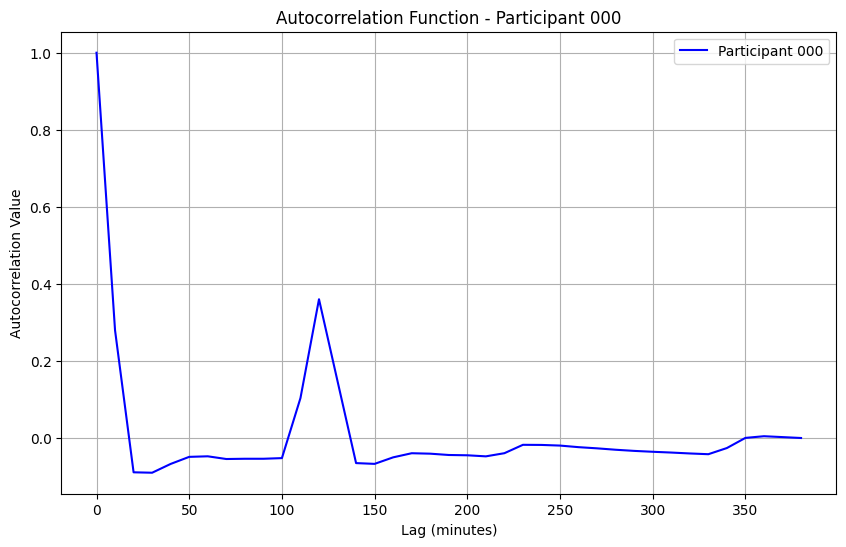

/tmp/ipykernel_2057/1446832698.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()
/tmp/ipykernel_2057/1446832698.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()
/tmp/ipykernel_2057/1446832698.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()
/tmp/ipykernel_2057/1446832698.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()
/tmp/ipykernel_2057/1446832698.py:16: Future

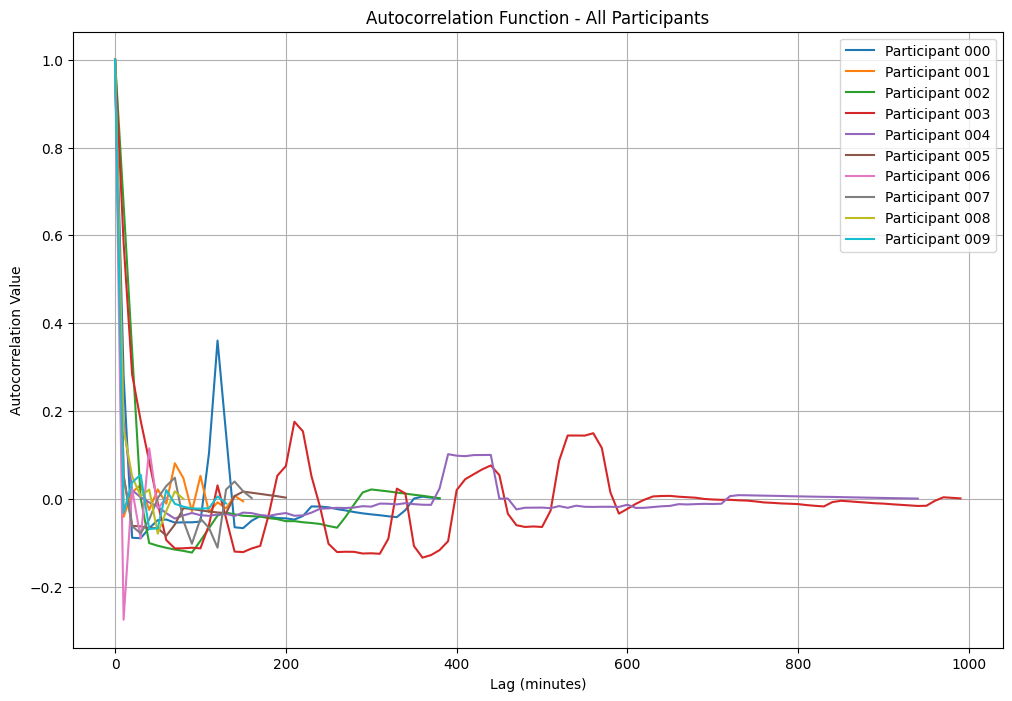

In [214]:
plot_acf_single(participant_data, '000') # Choose from Participants 000 to 009
plot_acf_all(participant_data)

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, butter, filtfilt

def high_pass_filter(data, cutoff=0.1, fs=1):

    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(1, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

def compute_periodogram(data, interval=600, apply_filter=False, cutoff=0.1):

    data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
    data = data.dropna(subset=['Latitude'])

    try:
        data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()
    except Exception as e:
        raise ValueError(f"Error during resampling: {e}")

    time_series = data['Latitude'].values

    if apply_filter:
        fs = 1 / (interval / 3600)  
        time_series = high_pass_filter(time_series, cutoff=cutoff, fs=fs)

    frequencies, power = periodogram(time_series, fs=1 / (interval / 3600))  
    return frequencies, power



def plot_periodogram_single(participant_data, participant_id, apply_filter=False, cutoff=0.1):

    if participant_id not in participant_data:
        print(f"Participant {participant_id} not found.")
        return

    data = participant_data[participant_id]
    frequencies, power = compute_periodogram(data, apply_filter=apply_filter, cutoff=cutoff)

    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, power, color='blue')
    plt.yscale('log')
    if apply_filter:
        plt.title("Periodogram After High-Pass Filtering")
    else:
        plt.title(f"Periodogram - Participant {participant_id}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

def plot_periodogram_all(participant_data, apply_filter=False, cutoff=0.1):

    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(participant_data)))

    for i, (participant_id, data) in enumerate(participant_data.items()):
        frequencies, power = compute_periodogram(data, apply_filter=apply_filter, cutoff=cutoff)
        plt.plot(frequencies, power, label=f"Participant {participant_id}", color=colors[i], alpha=0.7)

    plt.yscale('log')
    if apply_filter:
        plt.title("Periodogram with High-Pass Filter - All Participants")
    else:
        plt.title("Periodogram - All Participants")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend(loc='upper right', fontsize='small', ncol=2, frameon=True, shadow=True, fancybox=True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2057/1998489829.py:33: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()


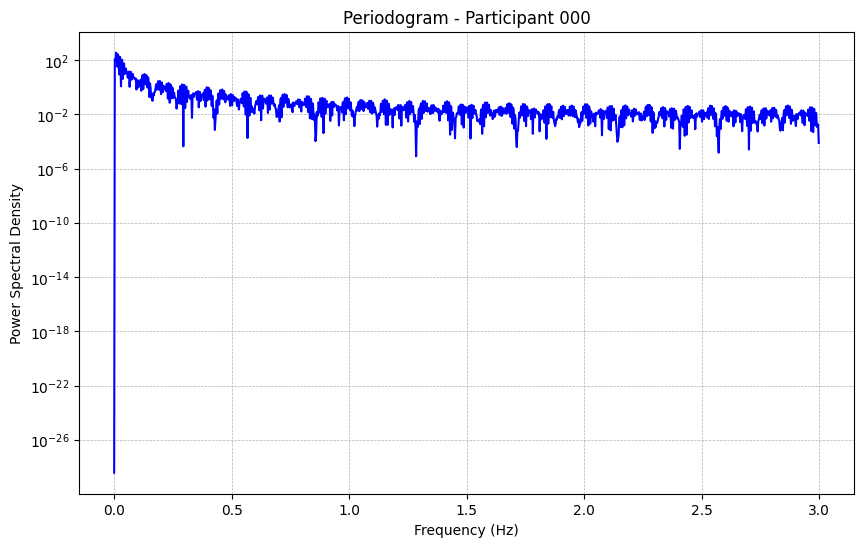

/tmp/ipykernel_2057/1998489829.py:33: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()
/tmp/ipykernel_2057/1998489829.py:33: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()
/tmp/ipykernel_2057/1998489829.py:33: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()
/tmp/ipykernel_2057/1998489829.py:33: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data = data[['Datetime', 'Latitude']].set_index('Datetime').resample(f'{interval}S').mean().dropna()
/tmp/ipykernel_2057/1998489829.py:33: Future

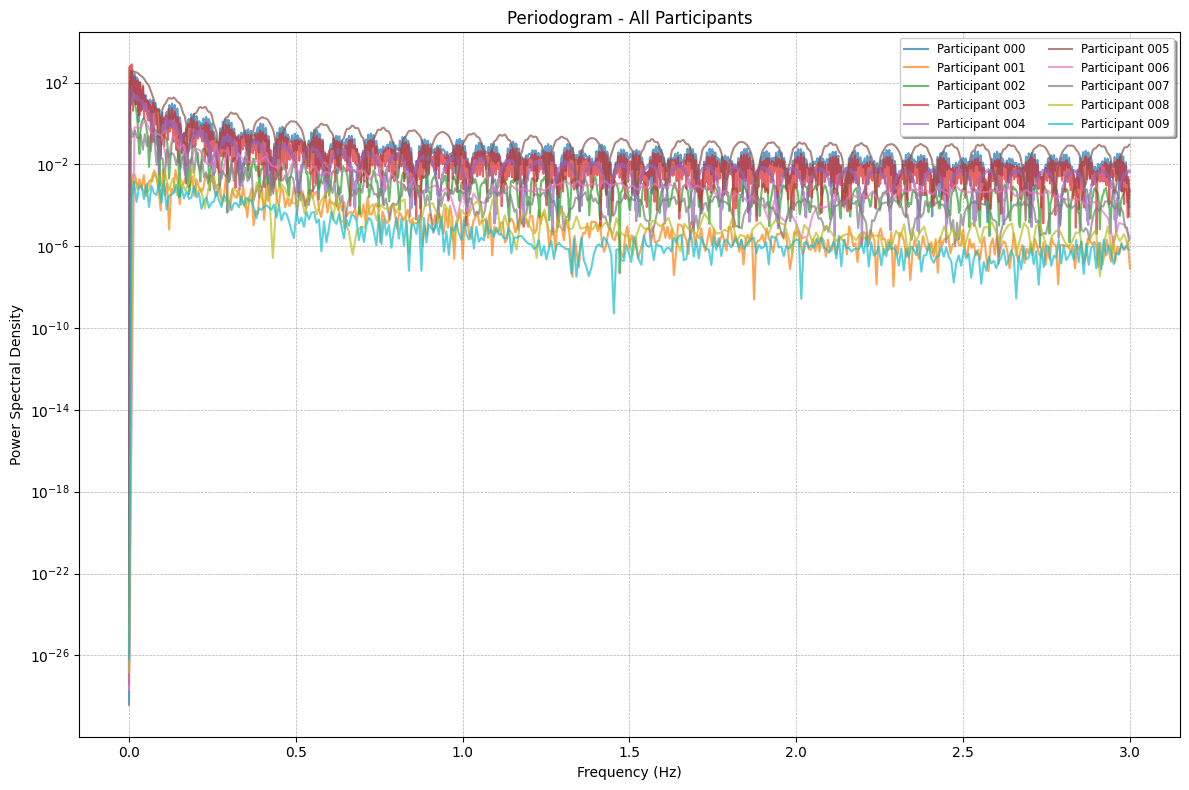

In [229]:
plot_periodogram_single(participant_data, '000')
plot_periodogram_all(participant_data)